In [1]:
from dotenv import load_dotenv
env_loaded = load_dotenv()
env_loaded

True

In [2]:
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from langchain_postgres import PGVector
import os

azure_deployment = "gpt-4o-mini"
# azure_deployment = "gpt-4o"
collection_name = "user_manual"

postgres_host = os.getenv("POSTGRES_HOST")
postgres_port = os.getenv("POSTGRES_PORT")
postgres_user = os.getenv("POSTGRES_USER")
postgres_db = os.getenv("POSTGRES_DB")
postgres_password = os.getenv("POSTGRES_PASSWORD")

connection = f"postgresql+psycopg://{postgres_user}:{postgres_password}@{postgres_host}:{postgres_port}/{postgres_db}"

model = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_deployment=azure_deployment,
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    temperature=0,
    max_tokens=8192,
)

embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-small", api_version="2024-02-01"
)

vectorstore = PGVector(
    embeddings=embeddings,
    collection_name=collection_name,
    connection=connection,
    use_jsonb=True,
)

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

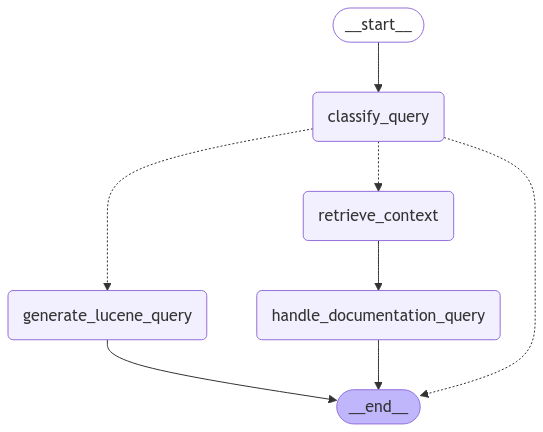

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage
from typing import Literal
from pydantic import BaseModel

class State(MessagesState):
    query_category: str
    context: str


class Classification(BaseModel):
    classified_result: Literal["OBJECT_SEARCH", "DOCUMENTATION_SEARCH"]


CLASSIFICATION_SYSTEM_PROMPT = """You are an expert in assisting users to answer queries related to polarion tool.
As a first step, you need to interpret the user provided query and classify it to one of the following categories.
The categories are: OBJECT_SEARCH, DOCUMENTATION_SEARCH

OBJECT_SEARCH category involves queries that are expected to be searched within the system and list them for user view.

DOCUMENTATION_SEARCH category involves queries that involves going through a documentation to explain the process or steps involved to navigate the application.

Here are few samples that covers both the categories. Do note that these examples are limited and should help you to interpret the user query and classify it based on the provided categories.

You are allowed to provide only one category for the given query.

Examples of queries that fall under OBJECT_SEARCH category:
1. List all the change requests created last week.
2. what are the tasks assigned to me that are in a pending state.
3. what are the new user stories created for the project Data Migration ?

Examples of queries that fall under DOCUMENTATION_SEARCH category:
1. How do I create a change request ?
2. How to reset password ?
3. I could not find the option to delete a change request.
4. How do I filter the tasks assigned to me ?
"""

GENERATE_LUCENE_QUERY_SYSTEM_PROMPT = """You are a Lucene query generator. Your task is to create accurate Lucene queries based on the provided field names, values, and query types. Follow the guidelines below to generate the queries:

**Instructions**:
- Use the provided `UserId` wherever applicable while generating the query.
- Ensure the syntax matches to that of Polarion application.

Example 1:
If user gives *Human Readable Query*: "Show all Task Workitems Assign to me"
and *UserId*: "458963"  then you should generate like *Lucene Query*: "type:task AND assignee.id:458963"

Example 2:
*Human Readable Query*: "Render Software Workitems that have specific comment"
*Lucene Query*: "type:softwarerequirement AND HAS_VALUE:comments.text"

Example 3:
*Human Readable Query*: "Display the Workitems which have Initial Estimate 1Day And Time Spent on a workitem should be 9h"
*Lucene Query*: "initialEstimate:1d AND timeSpent:9h"

Example 4:
*Human Readable Query*: "How to get workitems of type task & voice with open status"
*Lucene Query*: "type:(task voice) AND status:open"

Example 5:
*Human Readable Query*: "Show all Workitems created from 10-july-2024 to 30-Aug-2024"
*Lucene Query*: "created:[20240710 TO 20240830]"

Example 6:
*Human Readable Query*: "Filter Workitems based on Must Have Severity"
*Lucene Query*: "severity:must_have"

Example 7:
*Human Readable Query*: "Workitem which is assigned to me and status open and priority medium"
*Lucene Query*: "assignee.id:UserId AND status:open AND priority:medium"

Example 8:
*Human Readable Query*: "Workitem which are not assigned to me and status open and priority medium"
*Lucene Query*: "-assignee.id:UserId AND status:open AND priority:medium"  do not mention negative for the not mention please


**Note**: Do not mention *Lucene Query* this name in response; give only the generated query.
    Ensure that the syntax matches what is used in Polarion's documentation.
"""

POLARION_DOCUMENTATION_SYSTEM_PROMPT = """You are an expert on the Polarion user guide. Use the provided "Context" to accurately answer user queries.

Instructions:
1. **Context-Driven**: Respond based on the "Context" provided. If the query is outside the "Context", inform the user politely.
2. **No Fabrication**: Do not invent information; rely solely on the "Context".
3. **Handle Non-Contextual Queries**: For greetings, compliments, or conversation closures, respond appropriately without using the "Context".
4. **Be Clear and Detailed**: Provide concise and clear answers to assist the user effectively.

Maintain a professional tone in your responses.
"""

POLARION_DOCUMENTATION_USER_QUERY_TEMPLATE = """Using the provided context, answer the following query regarding the Polarion user guide.

User Query:
{user_query}

Context:
{context}

Provide a clear and accurate response.
"""


def classify_query(state: State):
    messages = [SystemMessage(CLASSIFICATION_SYSTEM_PROMPT)] + state["messages"]
    result = model.with_structured_output(Classification).invoke(messages)
    return {"query_category": result.classified_result}


def route_query(state: State):
    if state["query_category"] == "OBJECT_SEARCH":
        return "generate_lucene_query"
    
    if state["query_category"] == "DOCUMENTATION_SEARCH":
        return "retrieve_context"

    return END

def generate_lucene_query(state: State):
    messages = [SystemMessage(GENERATE_LUCENE_QUERY_SYSTEM_PROMPT)] + state["messages"]
    result = model.invoke(messages)
    return {"messages": [result]}

def retrieve_context(state: State):
    user_query = state["messages"][-1].content
    docs = retriever.invoke(user_query)
    context = "\n\n".join([d.page_content for d in docs])

    # Format docs
    return {"context": context}


def handle_documentation_query(state):
    user_query = state["messages"][-1].content
    user_prompt = HumanMessage(POLARION_DOCUMENTATION_USER_QUERY_TEMPLATE.format(
        user_query=user_query, context=state["context"]
    ))
    messages = [SystemMessage(GENERATE_LUCENE_QUERY_SYSTEM_PROMPT)] + [user_prompt]
    result = model.invoke(messages)
    return {"messages": [result]}

# Build graph
builder = StateGraph(State)
builder.add_node("classify_query", classify_query)
builder.add_node("generate_lucene_query", generate_lucene_query)
builder.add_node("retrieve_context", retrieve_context)
builder.add_node("handle_documentation_query", handle_documentation_query)

builder.add_conditional_edges(
    "classify_query",
    route_query,
    ["generate_lucene_query", "retrieve_context", END],
)

# Logic
builder.add_edge(START, "classify_query")
builder.add_edge("retrieve_context", "handle_documentation_query")
builder.add_edge("generate_lucene_query", END)
builder.add_edge("handle_documentation_query", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
messages = [HumanMessage("How do I create a requirement ?")]

## Non Streaming

In [ ]:
result = graph.invoke({"messages": messages})

for message in result["messages"]:
    message.pretty_print()

## Streaming

In [ ]:
nodes_to_stream = ["generate_lucene_query", "handle_documentation_query"]
async for event in graph.astream_events(
    {"messages": messages}, stream_mode="values", version="v2"
):
    # Get chat model tokens from a particular node
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node", "") in nodes_to_stream
    ):
        data = event["data"]
        print(data["chunk"].content, end="")

## Via LangGraph CLI

In [ ]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

assistants

In [ ]:
from langchain_core.messages import convert_to_messages


def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"


# Create a new thread
thread = await client.threads.create()
# Input message
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="polarion_assistant",
    input={"messages": messages},
    stream_mode="messages",
):
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)